# UI Normalization


In [1]:

import os
from dotenv import load_dotenv

load_dotenv()
URL = os.getenv('URL')
print(URL)
WINDOW_WIDTH, WINDOW_HEIGHT = 1280, 800

import shutil, pathlib
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from PIL import Image, ImageDraw, ImageFont
import datetime, pathlib
import json, time

folder_name = URL.rstrip("/").replace("://","_").replace("/","_")
out_dir = pathlib.Path(folder_name)

# --- nuke existing contents, keep the folder itself ---
if out_dir.exists():
    shutil.rmtree(out_dir)   
out_dir.mkdir(parents=True, exist_ok=True)

total_width, total_height = 1280, 800

https://github.com/facebook


In [2]:
# DOM Traversal

chrome_options = Options()
chrome_options.add_argument("--headless=new")
chrome_options.add_argument(f"--window-size={WINDOW_WIDTH},{WINDOW_HEIGHT}")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=chrome_options
)
driver.get(URL)

# Expand to full page dimensions
total_width = driver.execute_script(
    "return Math.max(document.body.scrollWidth, document.documentElement.scrollWidth);"
)
total_height = driver.execute_script(
    "return Math.max(document.body.scrollHeight, document.documentElement.scrollHeight);"
)
driver.set_window_size(total_width, total_height)
time.sleep(2)

# JavaScript to collect only visible, non-screen-reader text & image elements
js = '''
return (function() {

  /* ---------- helper utilities ---------- */
  function isStaticallyVisible(el) {
    if (el.closest && el.closest('.sr-only'))                 return false;
    if (el.closest && el.closest('details:not([open])'))      return false;

    let p = el;
    while (p) {
      const s = getComputedStyle(p);
      if (
        s.display === 'none' ||
        s.visibility === 'hidden' ||
        parseFloat(s.opacity) === 0 ||
        (s.clip && s.clip !== 'auto')
      ) return false;
      p = p.parentElement;
    }
    const r = el.getBoundingClientRect();
    if (
      r.width === 0 || r.height === 0 ||
      r.bottom < 0 || r.top  > window.innerHeight ||
      r.right  < 0 || r.left > window.innerWidth
    ) return false;
    return true;
  }

  function getElementXPath(el) {
    if (el.id) return 'id("' + el.id + '")';

    const parts = [];
    while (el && el.nodeType === Node.ELEMENT_NODE) {
      let idx = 1, sib = el.previousSibling;
      while (sib) {
        if (sib.nodeType === Node.ELEMENT_NODE &&
            sib.tagName.toLowerCase() === el.tagName.toLowerCase()) { idx++; }
        sib = sib.previousSibling;
      }
      parts.unshift(`${el.tagName.toLowerCase()}[${idx}]`);
      el = el.parentNode;
    }
    return '/' + parts.join('/');
  }

  const elements = [];

  /* ---------- 1a) Leaf TEXT NODES ---------- */
  const walker = document.createTreeWalker(
    document.body,
    NodeFilter.SHOW_TEXT,
    {
      acceptNode: node => {
        if (!node.textContent.trim()) return NodeFilter.FILTER_REJECT;
        const parent = node.parentElement;
        return (parent && isStaticallyVisible(parent))
          ? NodeFilter.FILTER_ACCEPT
          : NodeFilter.FILTER_REJECT;
      }
    }
  );

  let node;
  while ((node = walker.nextNode())) {
    const parent = node.parentElement;
    const range  = document.createRange();
    range.selectNodeContents(node);

    for (const r of range.getClientRects()) {
      elements.push({
        type:      'text',
        tight:     true,
        x:         r.x,
        y:         r.y,
        width:     r.width,
        height:    r.height,
        z:         parseFloat(getComputedStyle(parent).zIndex) || 0,
        payload:   node.textContent.trim(),
        tagName:   parent.tagName.toLowerCase(),
        id:        parent.id || null,
        classList: Array.from(parent.classList),
        role:      parent.getAttribute('role') || null,
        xpath:     getElementXPath(parent)
      });
    }
  }

  /* ---------- 1b) inline SVGs treated as images ---------- */
  Array.from(document.querySelectorAll('svg'))
    .filter(isStaticallyVisible)
    .forEach(el => {
      const r = el.getBoundingClientRect();
      if (r.width && r.height) {
        elements.push({
          type:      'image',              // keep the same “image” type
          tight:     false,
          x:         r.x,
          y:         r.y,
          width:     r.width,
          height:    r.height,
          z:         parseFloat(getComputedStyle(el).zIndex) || 0,
          payload:   null,
          tagName:   'svg',
          id:        el.id || null,
          classList: Array.from(el.classList),
          role:      el.getAttribute('role') || null,
          xpath:     getElementXPath(el)
        });
      }
    });

/* ---------- 1c) <span> elements ---------- */
Array.from(document.querySelectorAll('span'))
  .filter(el => isStaticallyVisible(el) && el.children.length === 0)   // leaf <span>
  .forEach(el => {
    const r      = el.getBoundingClientRect();
    if (!r.width || !r.height) return;

    const style  = getComputedStyle(el);
    const hasBg  =
      style.backgroundColor &&
      style.backgroundColor !== 'rgba(0, 0, 0, 0)' &&    // not fully transparent
      style.backgroundColor.toLowerCase() !== 'transparent';

    /* treat coloured boxes as IMAGEs, everything else with text as TEXT */
    if (hasBg) {
      elements.push({
        type:      'image',         // ← coloured box
        tight:     false,
        x:         r.x,
        y:         r.y,
        width:     r.width,
        height:    r.height,
        z:         parseFloat(style.zIndex) || 0,
        payload:   null,            // could store style.backgroundColor if useful
        tagName:   'span',
        id:        el.id || null,
        classList: Array.from(el.classList),
        role:      el.getAttribute('role') || null,
        xpath:     getElementXPath(el)
      });
    } else if (el.textContent.trim()) {
      elements.push({
        type:      'text',          // ← regular text span
        tight:     false,
        x:         r.x,
        y:         r.y,
        width:     r.width,
        height:    r.height,
        z:         parseFloat(style.zIndex) || 0,
        payload:   el.textContent.trim(),
        tagName:   'span',
        id:        el.id || null,
        classList: Array.from(el.classList),
        role:      el.getAttribute('role') || null,
        xpath:     getElementXPath(el)
      });
    }
  });

  /* ---------- 2) <img> and background‑image elements (unchanged) ---------- */
  Array.from(
    document.querySelectorAll('img, [style*="background-image"]')
  )
  .filter(isStaticallyVisible)
  .forEach(el => {
    const r = el.getBoundingClientRect();
    elements.push({
      type:      'image',
      tight:     false,
      x:         r.x,
      y:         r.y,
      width:     r.width,
      height:    r.height,
      z:         parseFloat(getComputedStyle(el).zIndex) || 0,
      payload:   null,
      tagName:   el.tagName.toLowerCase(),
      id:        el.id || null,
      classList: Array.from(el.classList),
      role:      el.getAttribute('role') || null,
      xpath:     getElementXPath(el)
    });
  });

  /* ---------- done ---------- */
  return elements;
})();
'''
elements = driver.execute_script(js)

# Save HTML snapshot
out_dir.mkdir(exist_ok=True)
with open(out_dir / "page.html", "w", encoding="utf-8") as f:
    f.write(driver.page_source)
print("Saved DOM →", out_dir / "page.html")

# Full‑page screenshot
screenshot_path = out_dir / "screenshot.png"
driver.save_screenshot(screenshot_path)
print("Saved screenshot →", screenshot_path)

driver.quit()
print(f"Collected {len(elements)} visual elements")


Saved DOM → https_github.com_facebook/page.html
Saved screenshot → https_github.com_facebook/screenshot.png
Collected 363 visual elements


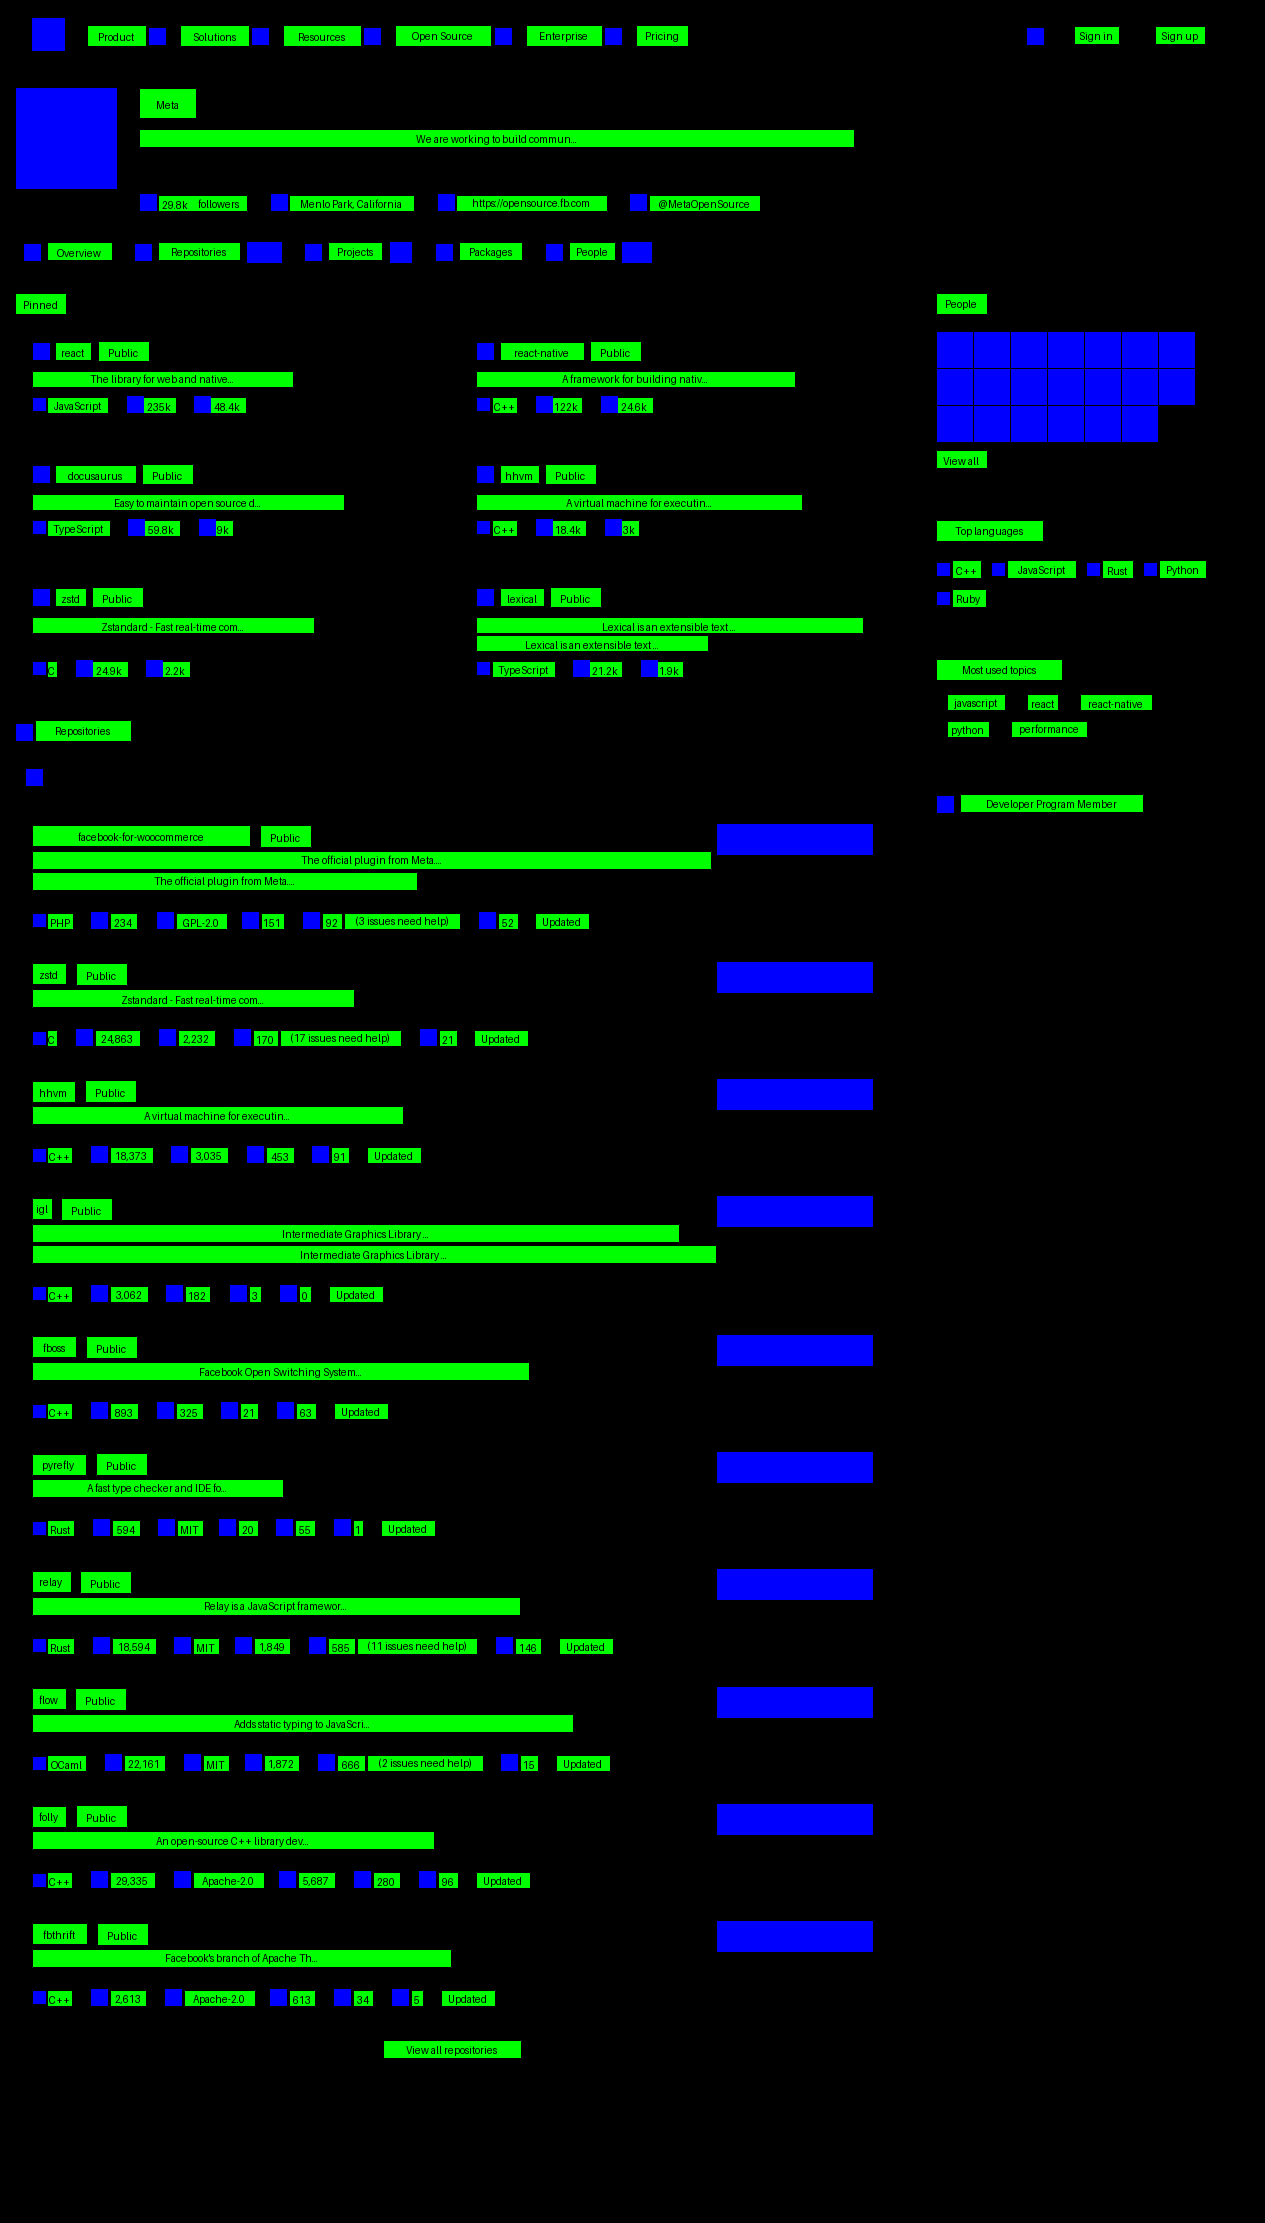

Saved → https_github.com_facebook/normalized.png
Saved elements → https_github.com_facebook/elements.json


In [3]:
# ── Visualize with PIL (filled green boxes + white text) ────────────────

font = ImageFont.load_default()
canvas = Image.new("RGB", (total_width, total_height), (0, 0, 0))
draw   = ImageDraw.Draw(canvas)

for el in elements:
    x, y, w, h = map(int, (el["x"], el["y"], el["width"], el["height"]))
    if w <= 0 or h <= 0:
        continue

    if el["type"] == "text":
        # Fill the box green
        draw.rectangle([x, y, x + w, y + h], fill=(0, 255, 0))

        # Prepare Text Label
        txt = (el.get("payload") or "")[:30] + (
            "…" if len(el.get("payload", "")) > 30 else ""
        )
        # Measure it
        l, t, r, b = draw.textbbox((0, 0), txt, font=font)
        tw, th = r - l, b - t

        # Center text inside the filled box
        tx = x + max(0, (w - tw) // 2)
        ty = y + max(0, (h - th) // 2)
        draw.text((tx, ty), txt, font=font, fill=(0, 0, 0))

    else:
        # Optionally fill image boxes a translucent blue
        draw.rectangle([x, y, x + w, y + h], fill=(0, 0, 255, 50))

# Display inline (in Jupyter)
display(canvas)

# And save out
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = pathlib.Path(out_dir) / f"normalized.png"
canvas.save(out_path)
print("Saved →", out_path)

out_dir.mkdir(exist_ok=True)                    # (already present later; harmless to keep twice
with open(out_dir / "elements.json", "w", encoding="utf-8") as f:
    json.dump(elements, f, ensure_ascii=False, indent=2)
print("Saved elements →", out_dir / "elements.json")
